In this script regularisation methods will be used to try and impove on the predictive performance obatained in the previous script where no regularistion was used. In particular the use of a stoping 
rule and a dropout layer will be explored.

In [1]:
import numpy as np
import pandas_datareader as pdr

In [2]:
df = pdr.get_data_yahoo('NVDA')
X = df.iloc[:, [0, 1, 2, 4, 5]]
y = df.iloc[:, 3:4]

In [3]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

I have added a dropout layer to the LSTM1 object I used in the previous script.

In [4]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout_pr):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size * num_layers, 128) #fully connected 1
        self.dropout = nn.Dropout(dropout_pr) # add a droput layer 
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        out, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size * self.num_layers) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.dropout(out)
        out = self.fc(out) #Final Output
        return out

Similar to train_model fucntion in previous notebook. The difference is that loss change, dropout_pr and learning rate have been added as input.

A stopping rule based on loss change is used as opposed to one based on a fixed number of iterations. This is beacuse the loss landscape for each fold is likley to be diffrent so a diffrent number of iterations may to needed to converge to that optimal level. The change in loss is measursed over 100 iterations. So, if after 100 iterations the change in loss falls behind the predefined constant loss_change the training of the model terminates. 

In [5]:
def train_model(X_train, y_train, loss_change = 0.01, dropout_pr = 0.25, lr = 0.001):
    """
    This function takes a train dataset as input and oupputs a trained model. 
    
    """
    #First reinalitialse the model
    num_epochs = 10000
    learning_rate = lr #0.001 lr

    input_size = 5 #number of features
    hidden_size = 150 #number of features in hidden state
    num_layers = 1 #number of stacked lstm layers

    num_classes = 1 #number of output classes
    
    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train.shape[1], dropout_pr)
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)
    
    previous_loss = 100000 # intialise previous loss as large 
    torch.manual_seed(16) # set seed to get reproducibility of results

    
    
    for epoch in range(num_epochs):
        outputs = lstm1.forward(X_train) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
        
        # obtain the loss function
        loss = criterion(outputs, y_train)
 
        loss.backward() #calculates the loss of the loss function
 
        optimizer.step() #improve from loss, i.e backprop
        
        if epoch % 100 == 0: # Every 100th iteration
            if 1 - (loss.item() / previous_loss) < loss_change: # if previous less than loss_change
                print('Number of epochs and loss:',epoch, loss.item())
                break
            else:
                previous_loss = loss.item() # or set previous loss to cuurent loss
            
        if epoch == num_epochs - 1: # if model has not converged within 1000 iterations 
            print('Model has not converged consider deacreasing loss change!')
            print('Its loss is currently;', loss.item())
    
        
    return lstm1

This funciton splits the given dataset into the given number of folds. Then trains a model on all the data available up to the given fold. Notice how default values of 200 test samples and 8 folds have been used. So, 8 models are trained and are tested on samples up to 25 days in advance. This strikes a nice balance between predictive efficiency and computational efficiency. 

In [6]:
def cross_validate(X_data, y_data, no_test = 200, no_fold = 8, loss_change = 0.01, dropout_pr = 0.25, lr = 0.001):
    
    """
    X_data and y_data must be in the numpy array format. Also, the number of samples must be
    divisible by the number of folds. 
    
    """
    
    train_size = y_data.size - no_test # size of the train set

    if no_test % no_fold == 0:
        fold_size = int(no_test / no_fold) # The number of test samples in each fold
    else:
        print('The test size must be divisible by the fold size!')
        return None 
    
    test_prediction = np.zeros(no_test) # To store all predicted labels
    train_mses = np.zeros(no_fold) # To store train MSE for each fold

    torch.manual_seed(16) # set seed to get reproducibility of results

    for i in range(no_fold):

        # First we prepare the train set for the fold 
        X_train = X_data[i * fold_size : train_size + i * fold_size, :] 
        X_test = X_data[train_size + i * fold_size : train_size + fold_size + i * fold_size, :] 
        y_train = y_data[i * fold_size : train_size + i * fold_size, :] 
        y_test = y_data[train_size + i * fold_size : train_size + fold_size + i * fold_size, :]

        X_train_tensors = Variable(torch.Tensor(X_train))
        X_test_tensors = Variable(torch.Tensor(X_test))
        y_train_tensors = Variable(torch.Tensor(y_train))
        y_test_tensors = Variable(torch.Tensor(y_test))

        #Reshape the train and test feaure samples to allow for timestamps 
        X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
        X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
    
        # Now we train the model for the current train set
        current_model = train_model(X_train_tensors_final, y_train_tensors, loss_change = loss_change, dropout_pr = dropout_pr, lr = lr)
        
        current_model.eval() # set model to evaluation mode to test performance 
        
        with torch.no_grad():
            fold_predict_test = current_model.forward(X_test_tensors_final)
            fold_predict_train = current_model.forward(X_train_tensors_final)
        
        fold_predict_test = fold_predict_test.data.numpy()
        fold_predict_test = np.reshape(fold_predict_test, fold_predict_test.size)
        test_prediction[i * fold_size : fold_size + i * fold_size] = fold_predict_test
        
        fold_predict_train = fold_predict_train.data.numpy()
        fold_train_mse = np.mean(np.sum(np.square(y_train - fold_predict_train)))
        train_mses[i] = fold_train_mse
    
        
        print(str(((i + 1) / no_fold) * 100) + ' % complete !')
    
    return test_prediction

## Data preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

#50 for training

X_data = X_ss[900:1200, :]
y_data = y_mm[901:1201, :] # shift over by 1 for next day 

In [8]:
y_data.shape

(300, 1)

## Stoping rule and no dropout 

In [9]:
Y_hat = cross_validate(X_data, y_data, loss_change = 0.01, dropout_pr = 0)

Number of epochs and loss: 400 0.00015938286378514022
12.5 % complete !
Number of epochs and loss: 1000 0.00015531307144556195
25.0 % complete !
Number of epochs and loss: 3700 9.721521200845018e-05
37.5 % complete !
Number of epochs and loss: 2700 9.960520401364192e-05
50.0 % complete !
Number of epochs and loss: 1400 0.00015363389684353024
62.5 % complete !
Number of epochs and loss: 1500 0.0003442642337176949
75.0 % complete !
Number of epochs and loss: 1300 0.0005923578282818198
87.5 % complete !
Number of epochs and loss: 1100 0.0007343927281908691
100.0 % complete !


Text(0.5, 1.0, 'With stoping rule but no dropout')

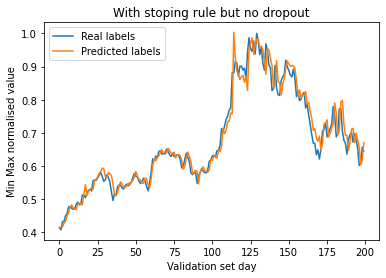

In [10]:
import matplotlib.pyplot as plt
plt.plot(y_data[-200:, :], label = 'Real labels')
plt.plot(Y_hat, label = 'Predicted labels')
plt.legend()
plt.xlabel('Validation set day')
plt.ylabel('Min Max normalised value')
plt.title('With stoping rule but no dropout')

Here, with the addtion of a stoping rule of less than a 0.01 change in loss the predicted labels mostly lie close to the real labels. However, there are certain predictions which are vastly different to their real values. This tends to happen when there is a change in trend such as the large spike at around day 120. This indicated that the model is paying too much attention to the pecularities in the past data rather than the data generating distribution for the labels. This suggests some overtraining is occuring. 
A look at the iterations to where the stoping rule is achived shows that for almost all folds over 1000 iterations have been used. In the previous notebook where 1000 iterations where used there where also clear signs of overtraing. So, it can be said that there is clear evidence that a stoping rule of 0.01 and no dropouts shows clear signs of overtraining. To prevent this a higher stoping rule should be used and/or the dropout layer should be activated.

## With stoping rule and dropout 

In [11]:
Y_hat = cross_validate(X_data, y_data, loss_change = 0.01, dropout_pr = 0.25)

Number of epochs and loss: 200 0.0019334334647282958
12.5 % complete !
Number of epochs and loss: 500 0.001639507245272398
25.0 % complete !
Number of epochs and loss: 500 0.0020281467586755753
37.5 % complete !
Number of epochs and loss: 500 0.0027644243091344833
50.0 % complete !
Number of epochs and loss: 500 0.0029820140916854143
62.5 % complete !
Number of epochs and loss: 500 0.004393129143863916
75.0 % complete !
Number of epochs and loss: 200 0.007449503056704998
87.5 % complete !
Number of epochs and loss: 200 0.008106826804578304
100.0 % complete !


Text(0.5, 1.0, 'With stoping rule with dropout')

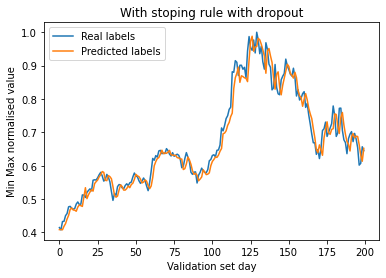

In [12]:
plt.plot(y_data[-200:, :], label = 'Real labels')
plt.plot(Y_hat, label = 'Predicted labels')
plt.legend()
plt.xlabel('Validation set day')
plt.ylabel('Min Max normalised value')
plt.title('With stoping rule with dropout')

In this case the general trend seems to followed and there are large mispredictions. However, there does seem to be a lag behind the trend. In addition, the smothness of the curve for the predicted labels could indicate some under training. So, there is certainly room for improvement via optimaisation of the hyperparameters.

## Optimisation of learning rate, stoping rules and dropout

Here, the optimal combinations of hyperparameters will be searched for. Previously, the need for the optimisation of the stopping rule and the learning rate has been discussed. Addtionally, the learning rate should also be optimised as it has just be set to a commonly used rate. Futhermore, the inverted dropout method makes the learning rate larger than it is so the lr should be optimised given a dropout probability.

Below I have modified the cross validate function so that it ouputs test and train MSE algonside predicted values.

In [13]:
def cross_validate(X_data, y_data, no_test = 200, no_fold = 8, loss_change = 0.01, dropout_pr = 0.25, lr = 0.001):
    
    """
    X_data and y_data must be in the numpy array format. Also, the number of samples must be
    divisible by the number of folds. 
    
    """
    
    train_size = y_data.size - no_test # size of the train set

    if no_test % no_fold == 0:
        fold_size = int(no_test / no_fold) # The number of test samples in each fold
    else:
        print('The test size must be divisible by the fold size!')
        return None 
    
    test_prediction = np.zeros(no_test) # To store all predicted labels
    train_mses = np.zeros(no_fold) # To store train MSE for each fold
    test_mses = np.zeros(no_fold)

    torch.manual_seed(16) # set seed to get reproducibility of results

    for i in range(no_fold):

        # First we prepare the train set for the fold 
        X_train = X_data[i * fold_size : train_size + i * fold_size, :] 
        X_test = X_data[train_size + i * fold_size : train_size + fold_size + i * fold_size, :] 
        y_train = y_data[i * fold_size : train_size + i * fold_size, :] 
        y_test = y_data[train_size + i * fold_size : train_size + fold_size + i * fold_size, :]

        X_train_tensors = Variable(torch.Tensor(X_train))
        X_test_tensors = Variable(torch.Tensor(X_test))
        y_train_tensors = Variable(torch.Tensor(y_train))
        y_test_tensors = Variable(torch.Tensor(y_test))

        #Reshape the train and test feaure samples to allow for timestamps 
        X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
        X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
    
        # Now we train the model for the current train set
        current_model = 0 # reset model varaible 
        current_model = train_model(X_train_tensors_final, y_train_tensors, loss_change = loss_change, dropout_pr = dropout_pr, lr = lr)
        
        current_model.eval() # set model to evaluation mode to test performance 
        
        with torch.no_grad():
            fold_predict_test = current_model.forward(X_test_tensors_final)
            fold_predict_train = current_model.forward(X_train_tensors_final)
        
        fold_predict_test = fold_predict_test.data.numpy()
        test_mses[i] = np.mean(np.square(y_test - fold_predict_test))
        fold_predict_test = np.reshape(fold_predict_test, fold_predict_test.size)
        test_prediction[i * fold_size : fold_size + i * fold_size] = fold_predict_test
        
        fold_predict_train = fold_predict_train.data.numpy()
        fold_train_mse = np.mean(np.square(y_train - fold_predict_train))
        train_mses[i] = fold_train_mse
    
        
        print(str(((i + 1) / no_fold) * 100) + ' % complete !')
    

    test_mse = np.mean(test_mses)
    train_mse = np.mean(train_mses)
    
    
    return test_prediction, test_mse, train_mse
    

The below cell shows the grid search script I have used to select the optimal hyperparameters. The selection is based on the selection of parameters which minimise test MSE. 

In [21]:
# The loss changes, dropout prs and learning rates that will be considered
loss_change = [0.05, 0.025, 0.01] 
dropout_pr = [0.25, 0.2, 0.15]
learning_rate = [0.001, 0.00075, 0.0005]

best_test_mse = 10000
iteration = 1

for loss in loss_change:
    for pr in dropout_pr:
        for lr in learning_rate:
            print('-----------------------')
            print('Iteration:', iteration)
            print('For loss change, dropout pr and learning rate:', loss, pr, lr)
            # get predictions and test/train mse for each combination 
            test_prediction, test_mse, train_mse = cross_validate(X_data, y_data, loss_change = loss, dropout_pr = pr, lr = lr)
            
            if test_mse < best_test_mse:
                best_test_prediction = test_prediction
                best_test_mse = test_mse
                best_train_mse = train_mse
                
                best_loss_change = loss
                best_dropout_pr = pr 
                best_lr = lr
            
            iteration += 1

print('------------------------')
print('All combinations have now been tried!')
print('The best loss change is:', best_loss_change)
print('The best dropout probability is:', best_dropout_pr)
print('The best learning rate is:', best_lr)
print('For the above optimal combination,')
print('The test mse is:', best_test_mse)
print('The train mse is:', best_train_mse)

-----------------------
Iteration: 1
For loss change, dropout pr and learning rate: 0.05 0.25 0.001
Number of epochs and loss: 200 0.0019334334647282958
12.5 % complete !
Number of epochs and loss: 500 0.001639507245272398
25.0 % complete !
Number of epochs and loss: 500 0.0020281467586755753
37.5 % complete !
Number of epochs and loss: 500 0.0027644243091344833
50.0 % complete !
Number of epochs and loss: 500 0.0029820140916854143
62.5 % complete !
Number of epochs and loss: 500 0.004393129143863916
75.0 % complete !
Number of epochs and loss: 200 0.007449503056704998
87.5 % complete !
Number of epochs and loss: 200 0.008106826804578304
100.0 % complete !
-----------------------
Iteration: 2
For loss change, dropout pr and learning rate: 0.05 0.25 0.00075
Number of epochs and loss: 200 0.001972393598407507
12.5 % complete !
Number of epochs and loss: 500 0.0017139684641733766
25.0 % complete !
Number of epochs and loss: 500 0.002086806343868375
37.5 % complete !
Number of epochs and l

Number of epochs and loss: 400 0.0013560816878452897
37.5 % complete !
Number of epochs and loss: 400 0.0026206476613879204
50.0 % complete !
Number of epochs and loss: 300 0.0030510518699884415
62.5 % complete !
Number of epochs and loss: 200 0.004260099492967129
75.0 % complete !
Number of epochs and loss: 400 0.003995219711214304
87.5 % complete !
Number of epochs and loss: 200 0.00601531844586134
100.0 % complete !
-----------------------
Iteration: 14
For loss change, dropout pr and learning rate: 0.025 0.2 0.00075
Number of epochs and loss: 200 0.001571443397551775
12.5 % complete !
Number of epochs and loss: 400 0.0009997609304264188
25.0 % complete !
Number of epochs and loss: 300 0.0019426298094913363
37.5 % complete !
Number of epochs and loss: 200 0.003074389649555087
50.0 % complete !
Number of epochs and loss: 400 0.0018674370367079973
62.5 % complete !
Number of epochs and loss: 300 0.0035737953148782253
75.0 % complete !
Number of epochs and loss: 200 0.00564962998032569

Number of epochs and loss: 200 0.0032566054724156857
75.0 % complete !
Number of epochs and loss: 400 0.0027959272265434265
87.5 % complete !
Number of epochs and loss: 200 0.004922692198306322
100.0 % complete !
-----------------------
Iteration: 26
For loss change, dropout pr and learning rate: 0.01 0.15 0.00075
Number of epochs and loss: 200 0.0012014282401651144
12.5 % complete !
Number of epochs and loss: 200 0.0010353288380429149
25.0 % complete !
Number of epochs and loss: 500 0.0013921787030994892
37.5 % complete !
Number of epochs and loss: 500 0.0017136767273768783
50.0 % complete !
Number of epochs and loss: 500 0.001748790848068893
62.5 % complete !
Number of epochs and loss: 500 0.0028032022528350353
75.0 % complete !
Number of epochs and loss: 200 0.004557890817523003
87.5 % complete !
Number of epochs and loss: 200 0.005446690134704113
100.0 % complete !
-----------------------
Iteration: 27
For loss change, dropout pr and learning rate: 0.01 0.15 0.0005
Number of epochs

## Plot of model predictions agansit real values using optimal hyperparameters

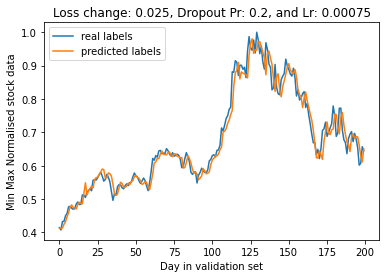

In [23]:
plt.plot(y_data[-200:, :], label = 'real labels')
plt.plot(best_test_prediction, label = 'predicted labels')
plt.title('Loss change: ' + str(best_loss_change) + ', ' + 'Dropout Pr: ' + str(best_dropout_pr) + ', and ' + 'Lr: ' + str(best_lr))
plt.xlabel('Day in validation set')
plt.ylabel('Min Max Normalised stock data')
plt.legend()

In this plot there seems to be no obvious predicted outliers as seen in the plot of predicted values using a stoping rule and no dropout. Futhermore, there seems to be a smaller lag between real and predicted values which has seen in the plot of a stoping rule of 0.01 and a dropout probabilty of 0.3.
So, it can be said that optimisation of hyperparaters has improved predictive performance.

It must be noted that the above plot uses the validation set which was used to select the optimal parameters. To gaugue an an good idea about how a model performs completly unseen data is desired. So, to better analyses this models predictive performance i will use the last 56 days in the yahoo data set. This has not been used in training or as a validation set for selction of hyperparameters.

## Analysis of the models predictive performance 


As mentioned above I will be using a completetly unseen portion of the yahoo data set (final 56 days).
This model is used to make next day predictions so I will be using all the available data up to a given day to analyse it's performance. This is different to the method used in hyperparameter selction where predctions where made over folds of 25 days. Howvever, in this case computational power is less of an issue as hyperparamters have already been selected. 

In [41]:
# First i will obtain the train / test set
X_data = X_ss[1101:1257]
y_data = y_mm[1102:]

print('X shape:', X_data.shape)
print('Y shape:', y_data.shape)

X shape: (156, 5)
Y shape: (156, 1)


In [44]:
test_prediction, test_mse, train_mse = cross_validate(X_data, y_data, no_test = 56, no_fold = 56, loss_change = 0.025, dropout_pr = 0.2, lr = 0.00075)


Number of epochs and loss: 300 0.006761465687304735
1.7857142857142856 % complete !
Number of epochs and loss: 200 0.006128630600869656
3.571428571428571 % complete !
Number of epochs and loss: 200 0.006789897568523884
5.357142857142857 % complete !
Number of epochs and loss: 500 0.006537984125316143
7.142857142857142 % complete !
Number of epochs and loss: 200 0.0070588113740086555
8.928571428571429 % complete !
Number of epochs and loss: 300 0.006350903306156397
10.714285714285714 % complete !
Number of epochs and loss: 200 0.006316970102488995
12.5 % complete !
Number of epochs and loss: 200 0.006342488341033459
14.285714285714285 % complete !
Number of epochs and loss: 700 0.0063023678958415985
16.071428571428573 % complete !
Number of epochs and loss: 200 0.00805971585214138
17.857142857142858 % complete !
Number of epochs and loss: 400 0.00589145440608263
19.642857142857142 % complete !
Number of epochs and loss: 300 0.007063442375510931
21.428571428571427 % complete !
Number of 

In [43]:
print(test_mse)


0.0013300823497371683


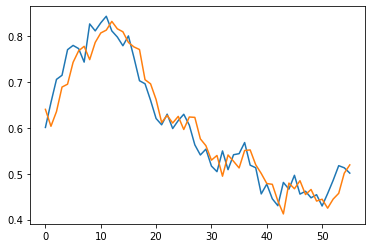

In [35]:
plt.plot(y_data[-56:])
plt.plot(test_prediction)